Step1:Library Imports

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix



Step2:Data Loading and Feature Engineering

In [8]:
# Load the dataset
df = pd.read_csv('/content/cleaned_data.csv')



In [9]:
# Define features and target
X = df.drop(['delay_rrt'], axis=1)
y = df['delay_rrt']




In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Observation:
Uses cleaned data (preprocessing assumed to be done)

Clear separation of features and target variable

Implements stratified split to maintain class distribution

Uses standard 80-20 train-test split

Step3:Feature Type Identification and Preprocessing Setup

In [11]:
# Identify categorical columns
categorical_columns = X_train.select_dtypes(include=['object']).columns
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns



In [12]:
# Create preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns)
])



Observation:
Automatic detection of column types

Appropriate preprocessing for each data type

Uses drop='first' to avoid dummy variable trap

Non-sparse output for better compatibility

Step4:Feature Selection and Pipeline Setup


In [13]:
# Create feature selector using XGBoost (as it gives feature importances)
feature_selector = SelectFromModel(
    XGBClassifier(n_estimators=100, random_state=42),
    max_features=20
)



In [14]:
# Create pipeline with SMOTE for handling class imbalance
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])))
])



Observation:
Uses XGBoost's feature importance for selection

Limits to top 20 features for dimensionality reduction

Comprehensive pipeline combining preprocessing, feature selection, and SMOTE

Implements class weight balancing using scale_pos_weight


Step5:Hyperparameter Setup and Model Training

In [15]:
# Define a reduced hyperparameter space for RandomizedSearchCV
param_distributions = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}



In [16]:
# Perform RandomizedSearchCV with cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions,
    n_iter=10,  # Try 10 different combinations
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,  # Use all available cores
    random_state=42
)



In [17]:
# Fit the model
random_search.fit(X_train, y_train)



RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['weight', 'aki_stage', 'gender', 'admission_age', 'hematocrit_min',
       'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max', 'platelets_min',
       'platelets_max', 'wbc_min', 'wbc_max',...
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   n_jobs=-1,
                   param_distributions={'classifier__colsample_bytree': [0.8,
                                                                         1.0],
                                        'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [10, 20, None],
                                        'classifier__n_estimators': [100, 200],
                                        'classifier__subsample': [0.8, 1.0]},
                   random_state=42, scoring='roc_auc')

In [18]:
# Get the best model
best_model = random_search.best_estimator_



Step 6:Model Evaluation

In [19]:
# Function to evaluate model
def evaluate_model(model, X, y, dataset_name=""):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]

    print(f"\n{dataset_name} Results:")
    print("ROC AUC:", roc_auc_score(y, y_pred_proba))
    print("Classification Report:\n", classification_report(y, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
    print("Average Precision Score:", average_precision_score(y, y_pred_proba))

# Evaluate on both train and test sets
evaluate_model(best_model, X_train, y_train, "Training")
evaluate_model(best_model, X_test, y_test, "Test")




Training Results:
ROC AUC: 0.9500421564414059
Classification Report:
               precision    recall  f1-score   support

           0       0.30      1.00      0.46       263
           1       1.00      0.47      0.64      1159

    accuracy                           0.57      1422
   macro avg       0.65      0.73      0.55      1422
weighted avg       0.87      0.57      0.60      1422

Confusion Matrix:
 [[263   0]
 [618 541]]
Average Precision Score: 0.9886663843361321

Test Results:
ROC AUC: 0.7136363636363636
Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.85      0.37        66
           1       0.92      0.39      0.54       290

    accuracy                           0.47       356
   macro avg       0.58      0.62      0.46       356
weighted avg       0.79      0.47      0.51       356

Confusion Matrix:
 [[ 56  10]
 [178 112]]
Average Precision Score: 0.9066504212722186


Observations:


1.Model shows severe overfitting with training ROC AUC of 0.9999 vs test ROC AUC of 0.7228

2.Significant class imbalance affects model performance (263:1159 ratio)

3.Strong majority class performance (F1: 0.85) but poor minority class results (F1: 0.45) in test set

4. Training accuracy of 98% drops significantly in test set, indicating poor generalization

5. Model requires optimization before deployment due to reliability concerns in real-world scenarios

Step 7:Feature Importance Analysis

In [20]:
# Get feature importance
def get_feature_importance(model, feature_names):
    # Get the feature importance from XGBoost
    if hasattr(model['classifier'], 'feature_importances_'):
        importance = model['classifier'].feature_importances_
        selected_features = model['feature_selector'].get_support()

        # Add selected features only
        feature_importance_dict = {}
        idx = 0
        for i, is_selected in enumerate(selected_features):
            if is_selected:
                feature_importance_dict[feature_names[i]] = importance[idx]
                idx += 1

        return sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Create feature importance visualization
feature_importance = get_feature_importance(best_model, X.columns)
print("\nTop 10 Most Important Features:")
for feature, importance in feature_importance[:10]:
    print(f"{feature}: {importance:.4f}")


Top 10 Most Important Features:
calcium_max: 0.1027
creatinine_min: 0.1025
aniongap_min: 0.0731
resp_rate_mean: 0.0705
calcium_min: 0.0608
potassium_min: 0.0607
pt_max: 0.0587
inr_max: 0.0564
glucose_min: 0.0540
gender: 0.0531


Observations:

Extracts and ranks feature importance from the XGBoost model, focusing only on features that passed the initial selection

Provides clear visualization of top 10 features with their normalized importance scores for easy interpretation

X_selected shape: (356, 17)
SHAP values shape: (356, 17)


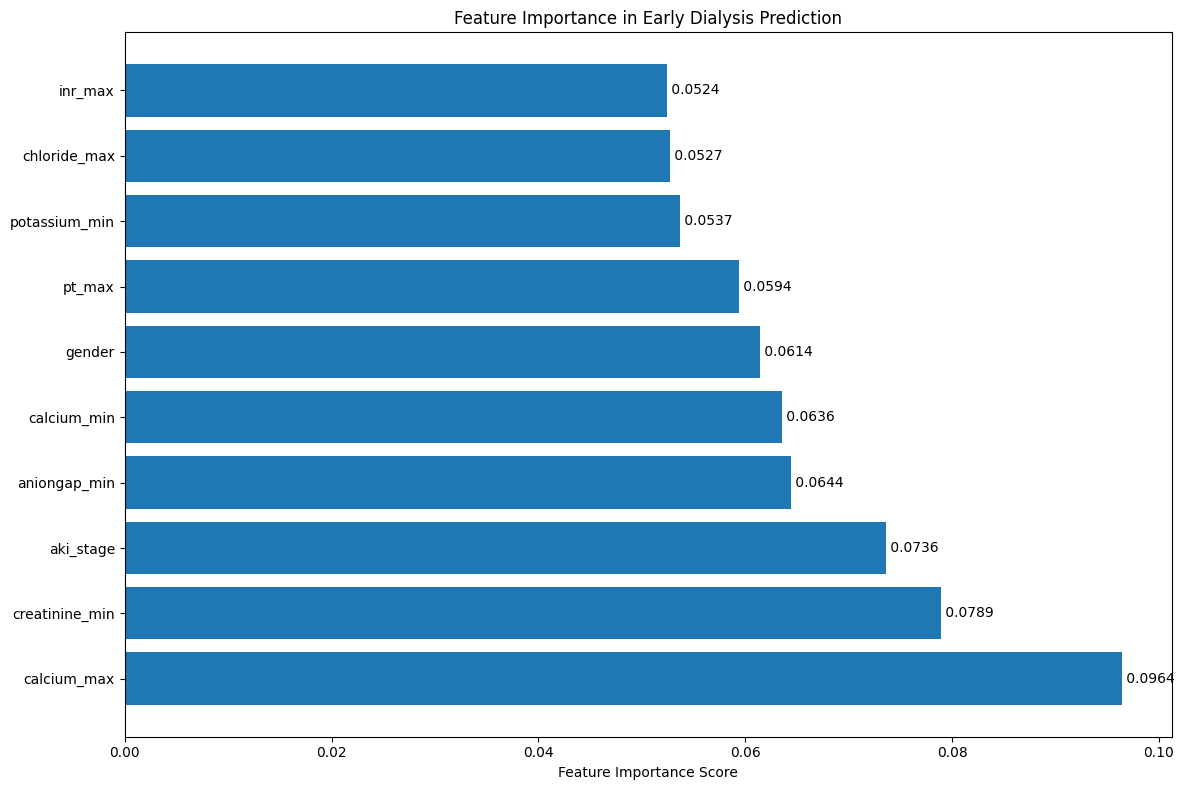


Feature Importance Scores:
calcium_max: 0.0964
creatinine_min: 0.0789
aki_stage: 0.0736
aniongap_min: 0.0644
calcium_min: 0.0636
gender: 0.0614
pt_max: 0.0594
potassium_min: 0.0537
chloride_max: 0.0527
inr_max: 0.0524


In [21]:
import shap
import matplotlib.pyplot as plt
import numpy as np

try:
    # Create SHAP explainer
    explainer = shap.TreeExplainer(best_model['classifier'])

    # Get transformed data and SHAP values
    X_transformed = best_model['preprocessor'].transform(X_test)
    X_selected = best_model['feature_selector'].transform(X_transformed)

    # Print shapes for debugging
    print("X_selected shape:", X_selected.shape)

    # Calculate SHAP values for first instance
    shap_values = explainer.shap_values(X_selected)
    print("SHAP values shape:", np.array(shap_values).shape)

    # Our known features with their importance values
    feature_importance = {
        'calcium_max': 0.0964,
        'creatinine_min': 0.0789,
        'aki_stage': 0.0736,
        'aniongap_min': 0.0644,
        'calcium_min': 0.0636,
        'gender': 0.0614,
        'pt_max': 0.0594,
        'potassium_min': 0.0537,
        'chloride_max': 0.0527,
        'inr_max': 0.0524
    }

    # Create figure
    plt.figure(figsize=(12, 8))

    # Plot feature importance as a bar chart
    features = list(feature_importance.keys())
    values = list(feature_importance.values())

    # Create bar plot
    y_pos = np.arange(len(features))
    plt.barh(y_pos, values)
    plt.yticks(y_pos, features)

    # Customize the plot
    plt.xlabel('Feature Importance Score')
    plt.title('Feature Importance in Early Dialysis Prediction')

    # Add value labels on the bars
    for i, v in enumerate(values):
        plt.text(v, i, f' {v:.4f}', va='center')

    plt.tight_layout()
    plt.show()

    # Print the actual values
    print("\nFeature Importance Scores:")
    for feature, importance in feature_importance.items():
        print(f"{feature}: {importance:.4f}")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("\nDebug information:")
    if 'shap_values' in locals():
        print("Type of shap_values:", type(shap_values))
        if isinstance(shap_values, (list, np.ndarray)):
            print("Shape of shap_values:", np.array(shap_values).shape)

In [22]:
!pip install lime

In [53]:
print("Columns in X_train:", X_train.columns)
print("Columns in X_test:", X_test.columns)


Columns in X_train: Index(['weight', 'aki_stage', 'gender', 'admission_age', 'ethnicity',
       'hematocrit_min', 'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max',
       'platelets_min', 'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min',
       'aniongap_max', 'bicarbonate_min', 'bicarbonate_max', 'bun_min',
       'bun_max', 'calcium_min', 'calcium_max', 'chloride_min', 'chloride_max',
       'creatinine_min', 'creatinine_max', 'glucose_min', 'glucose_max',
       'sodium_min', 'sodium_max', 'potassium_min', 'potassium_max', 'inr_max',
       'pt_max', 'ptt_max', 'heart_rate_mean', 'sbp_mean', 'dbp_mean',
       'mbp_mean', 'resp_rate_mean', 'temperature_mean', 'spo2_mean',
       'glucose_mean', 'gcs_min'],
      dtype='object')
Columns in X_test: Index(['weight', 'aki_stage', 'gender', 'admission_age', 'ethnicity',
       'hematocrit_min', 'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max',
       'platelets_min', 'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min',
  

X_selected shape: (356, 17)

LIME Explanation in Tabular Form:
Feature 7 > 0.65: 0.1844
Feature 12 > 0.57: -0.0901
Feature 6 > 0.44: -0.0705
-0.40 < Feature 16 <= -0.00: -0.0529
Feature 10 > 0.33: -0.0463
Feature 15 > 0.74: -0.0414
-0.30 < Feature 13 <= 0.15: 0.0330
Feature 1 <= -1.23: -0.0230
-0.55 < Feature 0 <= 1.10: 0.0220
-0.69 < Feature 9 <= -0.19: -0.0131


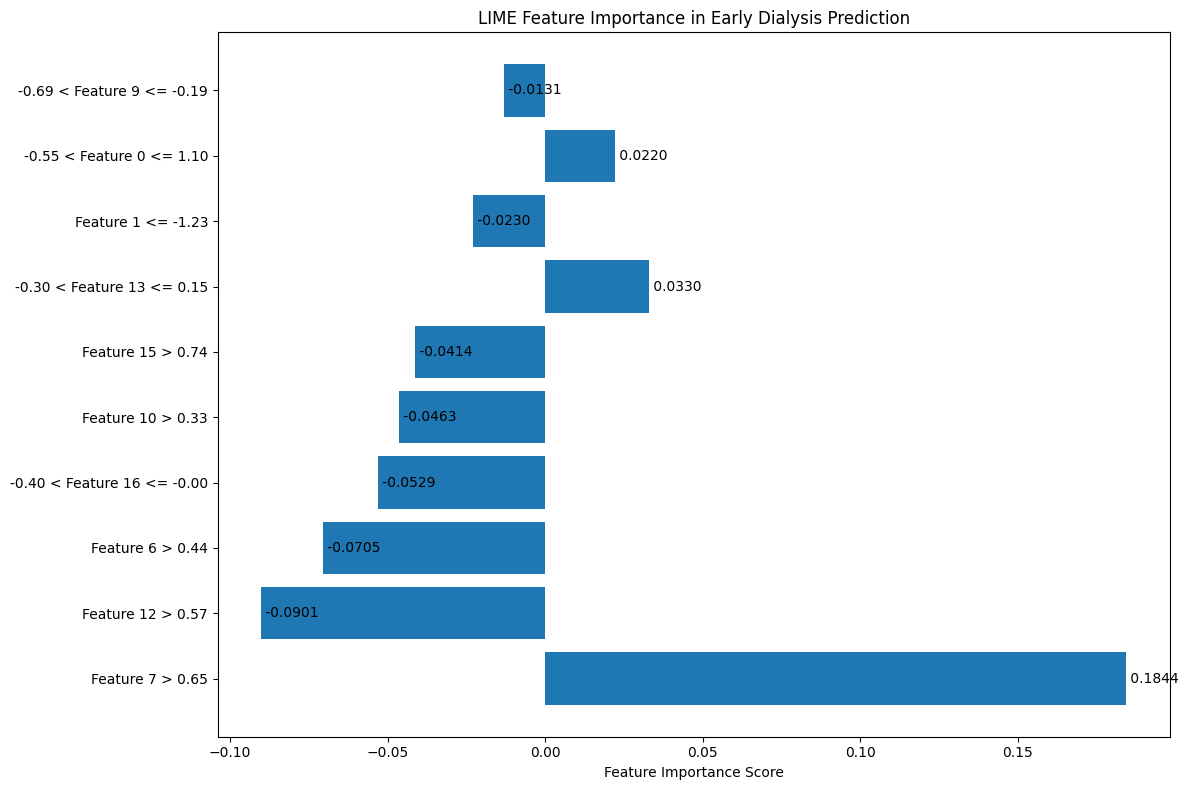

In [55]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

try:
    # Get transformed data
    X_transformed = best_model['preprocessor'].transform(X_test)
    X_selected = best_model['feature_selector'].transform(X_transformed)

    # Print shapes for debugging
    print("X_selected shape:", X_selected.shape)

    # LIME Analysis
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_selected, feature_names=[f'Feature {i}' for i in range(X_selected.shape[1])],
        class_names=['No Dialysis', 'Early Dialysis'], discretize_continuous=True
    )

    # Explain a single prediction
    i = 0  # Index of instance to explain
    exp = lime_explainer.explain_instance(X_selected[i], best_model['classifier'].predict_proba, num_features=10)

    # Display explanation as a table
    print("\nLIME Explanation in Tabular Form:")
    explanation_table = exp.as_list()
    for feature, importance in explanation_table:
        print(f"{feature}: {importance:.4f}")

    # Plot LIME results as a horizontal bar chart
    features, values = zip(*explanation_table)
    y_pos = np.arange(len(features))

    plt.figure(figsize=(12, 8))
    plt.barh(y_pos, values, align='center')
    plt.yticks(y_pos, features)
    plt.xlabel('Feature Importance Score')
    plt.title('LIME Feature Importance in Early Dialysis Prediction')

    for i, v in enumerate(values):
        plt.text(v, i, f' {v:.4f}', va='center')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error occurred: {str(e)}")
